<a href="https://colab.research.google.com/github/zangell44/DS-Unit-2-Sprint-4-Model-Validation/blob/master/DS_Unit_2_Sprint_Challenge_4_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

In [0]:
# imports

# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# sklearn
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, make_scorer

from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [0]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [238]:
# create our X and y variables
X = df.drop('made_donation_in_march_2007', axis=1)
y = df['made_donation_in_march_2007']

assert X.isnull().sum().sum() == 0
assert y.isnull().sum().sum() == 0

majority_class = y.mode()[0]
y_pred = [majority_class] * y.shape[0]
print ('Accuracy Score %.3f' % (accuracy_score(y, y_pred)))

Accuracy Score 0.762


What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

In [239]:
print ('Recall Score %.3f' % (recall_score(y, y_pred)))

Recall Score 0.000


Based on class imbalance alone, we're able to correctly identify the majority of samples. Around 76% of people in the dataset did not give blood.

Recall is more nuanced. Scikit-learn automatically assumes that we want the recall score of the *positive* label. In the case above, we're always guessing the negative label. This is obviously very poor performance if we are indeed only concerned about recall score of the positive class.

Recall for the negative class, however, is 100%. It's beneficial to look at all performance metrics for our simple majority classifier. This allows us to examine recall scores for different classes and class weightings.

In [240]:
print ('Classification Report (Majority Classifier Baseline)\n\n', classification_report(y, y_pred))

Classification Report (Majority Classifier Baseline)

               precision    recall  f1-score   support

           0       0.76      1.00      0.86       570
           1       0.00      0.00      0.00       178

   micro avg       0.76      0.76      0.76       748
   macro avg       0.38      0.50      0.43       748
weighted avg       0.58      0.76      0.66       748



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.25,
                                                   random_state=1,
                                                   shuffle=True)

## Part 1.3 Feature Engineering

Let's start by taking a look at the training data.

In [242]:
# lets first take a look at the distribution of our variables
X_train.describe()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation
count,561.000000,561.000000,561.000000,561.000000
mean,9.748663,5.561497,1390.374332,34.106952
std,8.341758,5.906130,1476.532510,24.401390
min,0.000000,1.000000,250.000000,2.000000
25%,4.000000,2.000000,500.000000,16.000000
50%,8.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,46.000000,11500.000000,98.000000


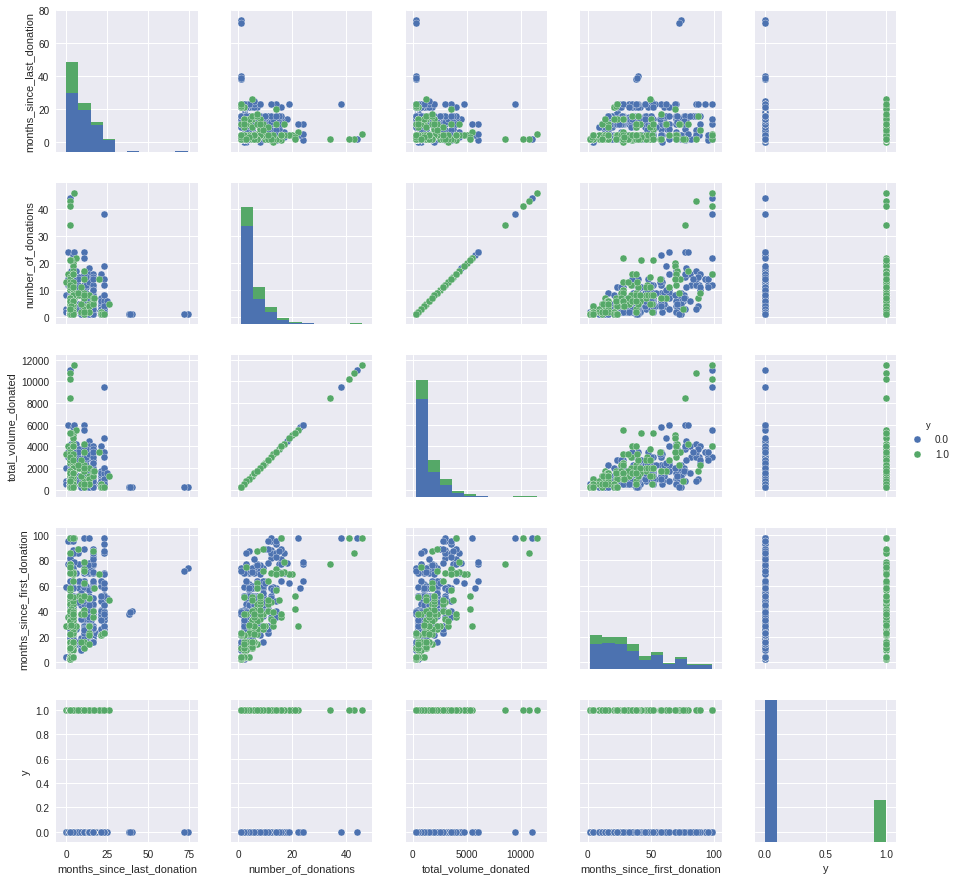

In [243]:
X_pairplot = X.copy()
X_pairplot['y'] = y_train
sns.pairplot(X_pairplot, hue='y');

A few takeaways:

- People who donated recently seem more likely to donate again
- People who donated more frequently or more volume per donation seem more likely to donate again
- All of our features are right-skewed, with fairly long tails for long time or frequent donors

In [244]:
def wrangle(X):
  # returns a modified dataframe with additional features
  # specific to the blood donations dataset
  
  # include log of all features to account for skewed data
  for col in X.columns:
    X['log_' + col] = np.log(X[col])
    
  # binary feature if someone hasn't donated in 3 years or more
  X['recent_donor'] = X['months_since_last_donation'] < 36
    
  # include donation and volume per donation rates
  X['donations_per_month'] = (X['number_of_donations'] / (X['months_since_first_donation'] - X['months_since_last_donation']))
  X['volume_per_month'] = (X['total_volume_donated'] / (X['months_since_first_donation'] - X['months_since_last_donation']))
  
  return X

# wrangle test and train data
X_train = wrangle(X_train).replace([np.inf, -np.inf, np.nan],0)
X_test = wrangle(X_test).replace([np.inf, -np.inf, np.nan],0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [0]:
pipeline_lr = make_pipeline(StandardScaler(),
                           SelectKBest(),
                           LogisticRegression(solver='lbfgs'))

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [246]:
# initialize parameter grid
param_grid = {'selectkbest__k' : np.arange(1, 10),
             'logisticregression__class_weight' : [None, 'balanced'],# {0: 1, 1:10}], <- this will obviously give you recall of 100% for positive class
             'logisticregression__C' : [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]}

# create scorer using AVERAGE of recall scores for both classes
recall_scorer = make_scorer(recall_score, pos_label=1, **{'average' : 'macro'})

# grid search for best parameters
gs = GridSearchCV(estimator=pipeline_lr,
                  param_grid=param_grid,
                  scoring=recall_scorer,
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**Please note** I'm using a modified recall score function above, not simply recall for the positive label.

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [247]:
print ('Best CV Recall Score (Training Data): %.3f' % gs.best_score_)
print ('\nFinal Hyperparameter Values:\n')
print (tabulate([[param, gs.best_params_[param]] for param in gs.best_params_], headers=['Hyperparameter', 'Optimal Value']))

Best CV Recall Score (Training Data): 0.669

Final Hyperparameter Values:

Hyperparameter                    Optimal Value
--------------------------------  ---------------
logisticregression__C             0.0001
logisticregression__class_weight  balanced
selectkbest__k                    1


If we're *only* trying to optimize recall score for the positive label, it's pretty easy to modify logistic regression class weights to ensure recall is 100%. Unsuprisingly, given we're optimizing for average recall score between classes, the optimal class weight is 'balanced'.

Let's look at some learning and validation curves for our training size and regularization parameter.

### Some Fun Learning and Validation Curves

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [8] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [8] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: U

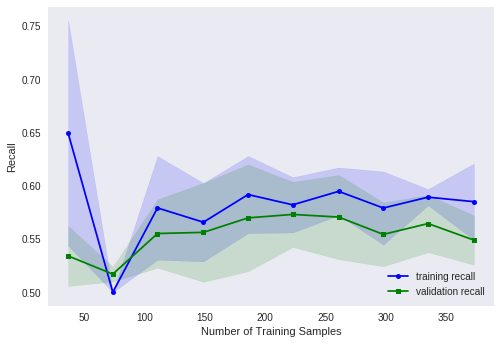

In [248]:
# examines how our model learns as it sees more samples
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipeline_lr,
                             X=X_train,
                             y=y_train,
                             scoring=recall_scorer,
                             train_sizes=np.linspace(0.1,1.0,10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='training recall')

plt.fill_between(train_sizes,
               train_mean + train_std,
               train_mean - train_std,
               alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', marker='s',
        markersize=5, label='validation recall')

plt.fill_between(train_sizes,
               test_mean + test_std,
               test_mean - test_std,
               alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()

The relationship between training and validation score appears to be stable after around 200 samples are observed.

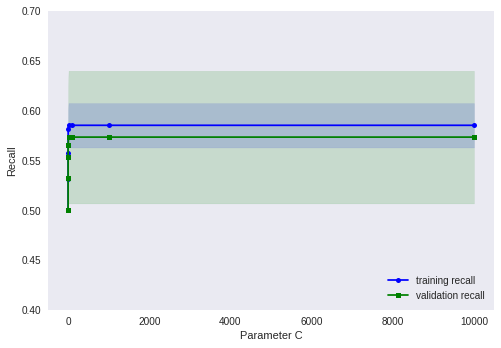

In [249]:
c_range = [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
train_scores, test_scores = validation_curve(estimator=pipeline_lr,
                                            X=X_train,
                                            y=y_train,
                                            scoring=recall_scorer,
                                            param_name='logisticregression__C',
                                            param_range=c_range,
                                            cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(c_range, train_mean,
        color='blue', marker='o',
        markersize=5, label='training recall')

plt.fill_between(c_range,
               train_mean + train_std,
               train_mean - train_std,
               alpha=0.15, color='blue')
plt.plot(c_range, test_mean,
        color='green', marker='s',
        markersize=5, label='validation recall')

plt.fill_between(c_range,
               test_mean + test_std,
               test_mean - test_std,
               alpha=0.15, color='green')
plt.grid()
plt.xlabel('Parameter C')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.ylim([0.4,0.7])
plt.show()

The relationship between training and test scores appears to be stable anywhere after a very small value for C.

### Final Features

Which features did our model end up selecting?

In [250]:
selected_mask = gs.best_estimator_.named_steps['selectkbest'].get_support() 

print('Features Selected:')
for name in X_train.columns[selected_mask]:
    print(name)

print('\nFeatures Not Selected:')
for name in X_train.columns[~selected_mask]:
    print(name)

Features Selected:
log_months_since_last_donation

Features Not Selected:
months_since_last_donation
number_of_donations
total_volume_donated
months_since_first_donation
log_number_of_donations
log_total_volume_donated
log_months_since_first_donation
recent_donor
donations_per_month
volume_per_month


### Evaluation on Test Data

Now, let's do a final evaluation on our test set, and look at our confusion matrix for the final model.

In [251]:
print ('Recall Score (Test Data): %.3f' % gs.score(X_test, y_test))

Recall Score (Test Data): 0.706


This testing score is satisfactory for our basic model for two reasons.

First, it significantly exceeds our baseline recall score of 0.5 (we kind of cheated using all the data but still).

Second, the testing score is very close to our best model's cross validation score on the training data, leading us to believe the model should generalize well.

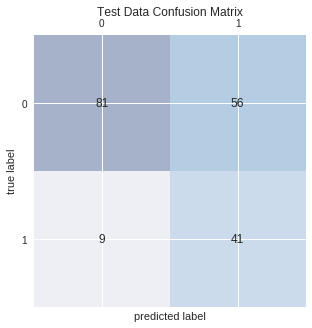

In [252]:
confmat = confusion_matrix(y_test, gs.predict(X_test))
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i, j],
               va='center', ha='center')
plt.title('Test Data Confusion Matrix')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [253]:
accuracy = (36 + 85) / (36 + 85 + 58 + 8)
print ('Accuracy Score: %.3f' % accuracy)

Accuracy Score: 0.647


Calculate precision

In [254]:
precision = (36) / (36 + 58)
print ('Precision Score: %.3f' % precision)

Precision Score: 0.383


Calculate recall

In [255]:
recall = (36) / (36 + 8)
print ('Recall Score: %.3f' % recall)

Recall Score: 0.818


Calculate F1 score

In [256]:
f1 = 2  * (precision * recall) / (precision + recall)
print ('F1 Score: %.3f' % f1)

F1 Score: 0.522


Calculate False Positve Rate

In [257]:
fpr = 58 / (58 + 85)
print ('False Positive Rate: %.3f' % fpr)

False Positive Rate: 0.406


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 